In [1]:
import json
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import nltk
import re
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA

In [2]:
ecse_math_comp_2018 = pd.read_csv('2018_3_dept_information.csv')
course_df = pd.read_csv("all_course_at_mcgill.csv", lineterminator='\n')
comp_long_term = pd.read_csv('compsci_30terms.csv')
features = ['course_number', 'term', 'days', 'location', 'sec_type', 'time_start']

Below are a few questions asked by myself, as a McGill student... Please scroll down for graphs. There are plenty of codes...

# 1. How many courses are avaliable in each term?

In [3]:
count = [0, 0, 0, 0]
for li in course_df['semesters'].values: 
    if 'Fall' in li: 
        count[0] = count[0] + 1
    if 'Winter' in li: 
        count[1] = count[1] + 1
    if 'Summer' in li: 
        count[2] = count[2] + 1
    if 'set()' in li: 
        count[3] = count[3] + 1
print('Answer: Fall: {}, Winter: {}, Summer: {}, Empty: {}'.format(count[0], count[1], count[2], count[3]))

Answer: Fall: 3804, Winter: 3845, Summer: 1009, Empty: 3885


## 1.1 Are all courses available at least for 1 term? 

In [4]:
sem_count = course_df['semesters'].value_counts()
sem_count

set()                           3885
{'Winter'}                      2128
{'Fall'}                        2072
{'Fall', 'Winter'}              1019
{'Summer', 'Fall', 'Winter'}     642
{'Summer'}                       240
{'Summer', 'Fall'}                71
{'Summer', 'Winter'}              56
Name: semesters, dtype: int64

Conclusion: No, actually, McGill has 3885 closed courses...which is the largest among all categories (Fall: 3804, Winter: 3845, Summer: 1009, Empty: 3885). 

## 1.2 How are the courses distributed jointly @ faculty and term? 

In [5]:
facc_dens = np.zeros((len(course_df['faculty'].unique()), 4))
i = 0
for facc in course_df['faculty'].unique(): 
    semes_of_facc = course_df.loc[course_df['faculty'] == facc]['semesters'].astype(str).value_counts()
    for key, val in semes_of_facc.iteritems(): 
        if key.find('Fall') != -1: 
            facc_dens[i][0] = facc_dens[i][0] + val
        if key.find('Winter')!=-1: 
            facc_dens[i][1] = facc_dens[i][1] + val
        if key.find('Summer') != -1: 
            facc_dens[i][2] = facc_dens[i][2] + val
        if key.find('set()') != -1: 
            facc_dens[i][3] = facc_dens[i][3] + val
    i = i + 1

count density

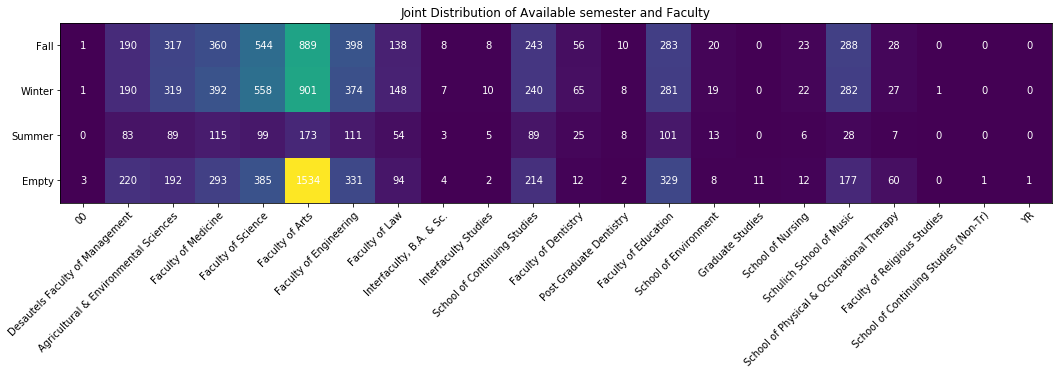

In [6]:
vert_label = ['Fall', 'Winter', 'Summer', 'Empty']
fig2, ax2 = plt.subplots(figsize = (15,30))
im2 = ax2.imshow(facc_dens.T, cmap = 'viridis')

ax2.set_xticks(np.arange(len(course_df['faculty'].unique())))
ax2.set_yticks(np.arange(len(vert_label)))

ax2.set_xticklabels(course_df['faculty'].unique())
ax2.set_yticklabels(vert_label)

plt.setp(ax2.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

for i in range(len(vert_label)):
    for j in range(len(course_df['faculty'].unique())):
        text = ax2.text(j, i, int(facc_dens[j, i]), ha = "center", va = "center", color = "w")

ax2.set_title("Joint Distribution of Available semester and Faculty")
fig2.tight_layout()

This plot indicates that most courses are available at fall and winter in most faculties. However, 1534 courses in Faculty of Arts are not available at all. 

# 2. What is the largest faculty at McGill? (Defined by number of courses available)

[]

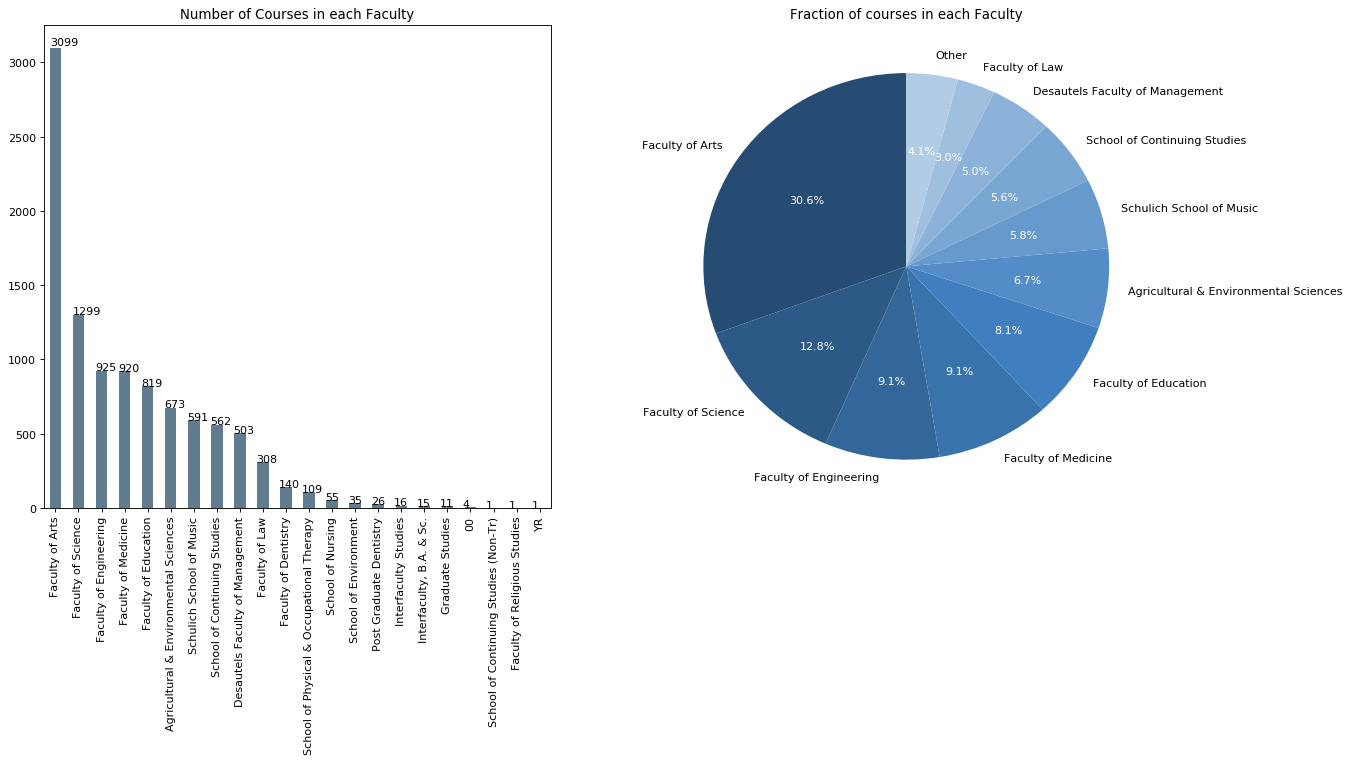

In [7]:
plt.figure(figsize = (18, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')

plt.subplot(1,2,1)

ax2 = course_df['faculty'].value_counts().plot(kind = 'bar', color = '#607c8e')
for p in ax2.patches:
    ax2.annotate(int(p.get_height()), (p.get_x() * 0.995, p.get_height() * 1.005))
plt.title('Number of Courses in each Faculty')

plt.subplot(1,2,2)

frac = list()
label = list()
total_others = 0
color_style = ['#264c73', '#2d5986', '#336699', '#3973ac', '#407fbf', '#538cc6', '#6699cc' , '#79a6d2', '#8cb2d9', '#9fbfdf', '#b3cce5', '#c6d9ec', '#d9e6f2' , '#ecf2f9']


for faculty_name, faculty_count in course_df['faculty'].value_counts().iteritems(): 
    if faculty_count > 150: 
        frac.append(faculty_count)
        label.append(faculty_name)
    else: 
        total_others = total_others + faculty_count
        
frac.append(total_others)
label.append('Other')

_, _, autotexts = plt.pie(frac, labels = label, startangle = 90, autopct = '%0.1f%%',  colors = color_style)

for autotext in autotexts:
    autotext.set_color('white')
plt.title('Fraction of courses in each Faculty')
plt.plot()

Conclusion: the largest faculty is Arts, which has 3099 courses, taking up for 30.6%. 

## 2.1 What is the largest department in each faculty? 

[]

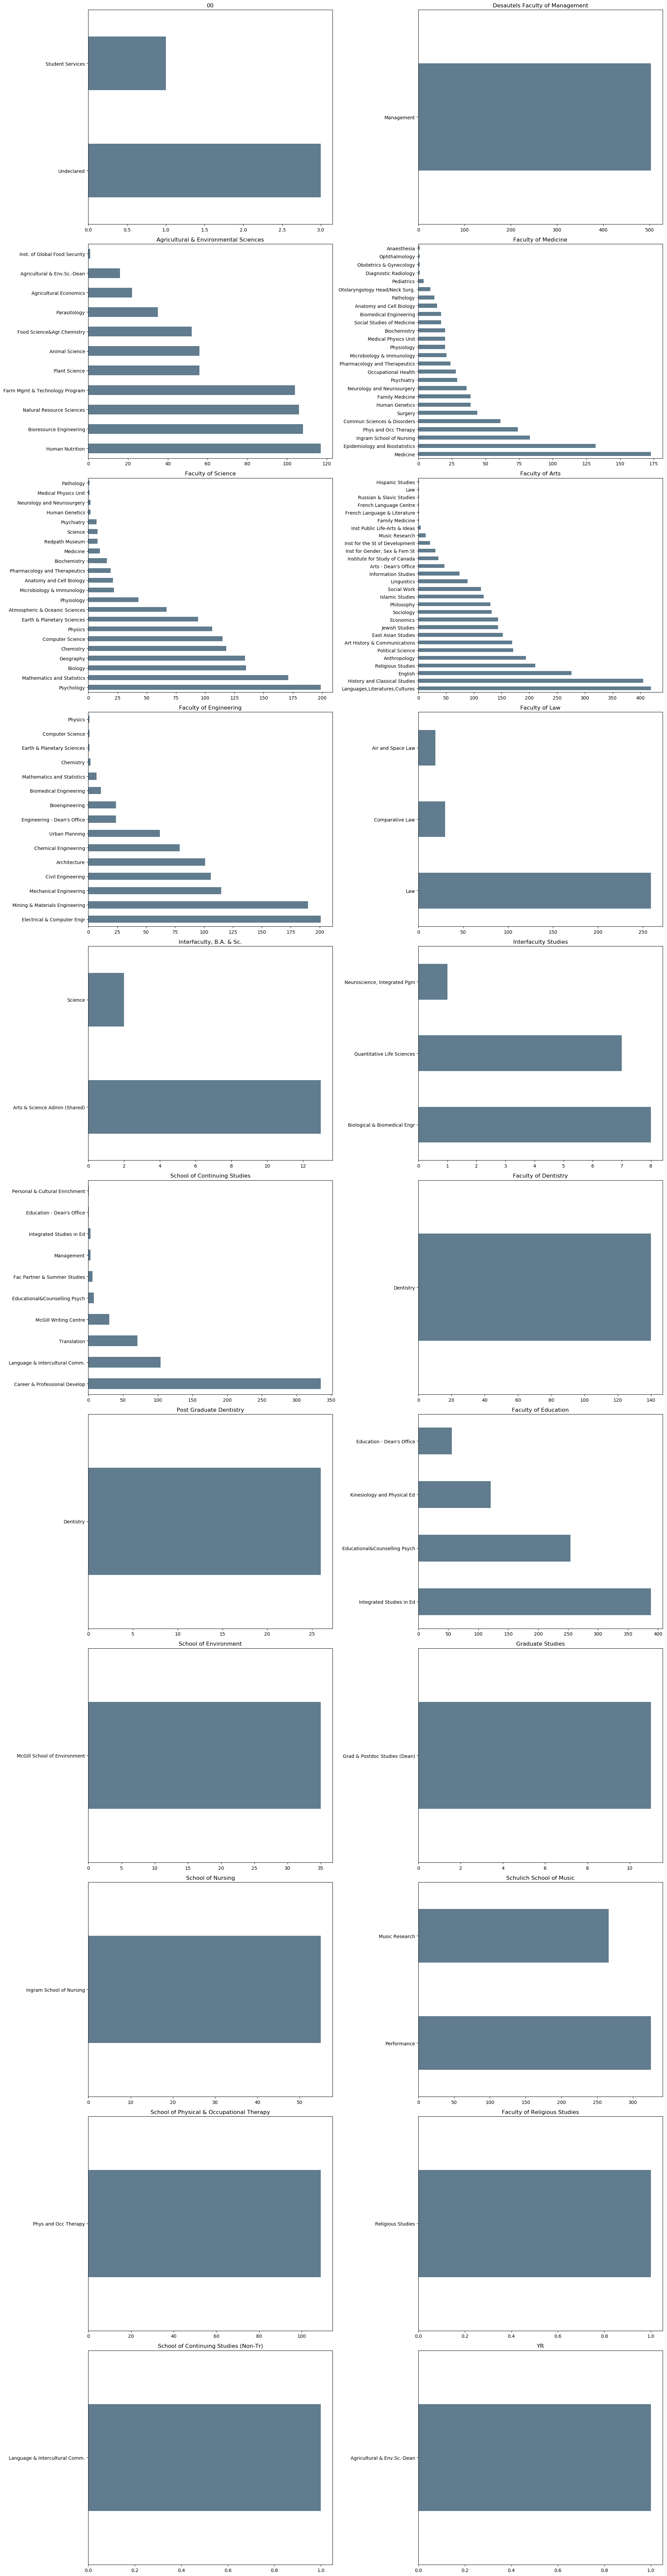

In [8]:
plt.figure(figsize = (20, 77), dpi = 100, facecolor = 'w', edgecolor = 'k')

faculties = course_df['faculty'].unique()

i = 1
for facc in faculties: 
    plt.subplot(11, 2, i)
    dept = course_df.loc[course_df['faculty'] == facc]['department']
    if not dept.empty: 
        dept.value_counts().plot(kind = 'barh', color = '#607c8e')
        plt.title(facc)
    i = i + 1
    plt.tight_layout()
plt.plot()

For each subplot, longest bar represent largest department. 

# 3. How are course credits distributed in each Faculty? Are some faculties have courses with larger credits?

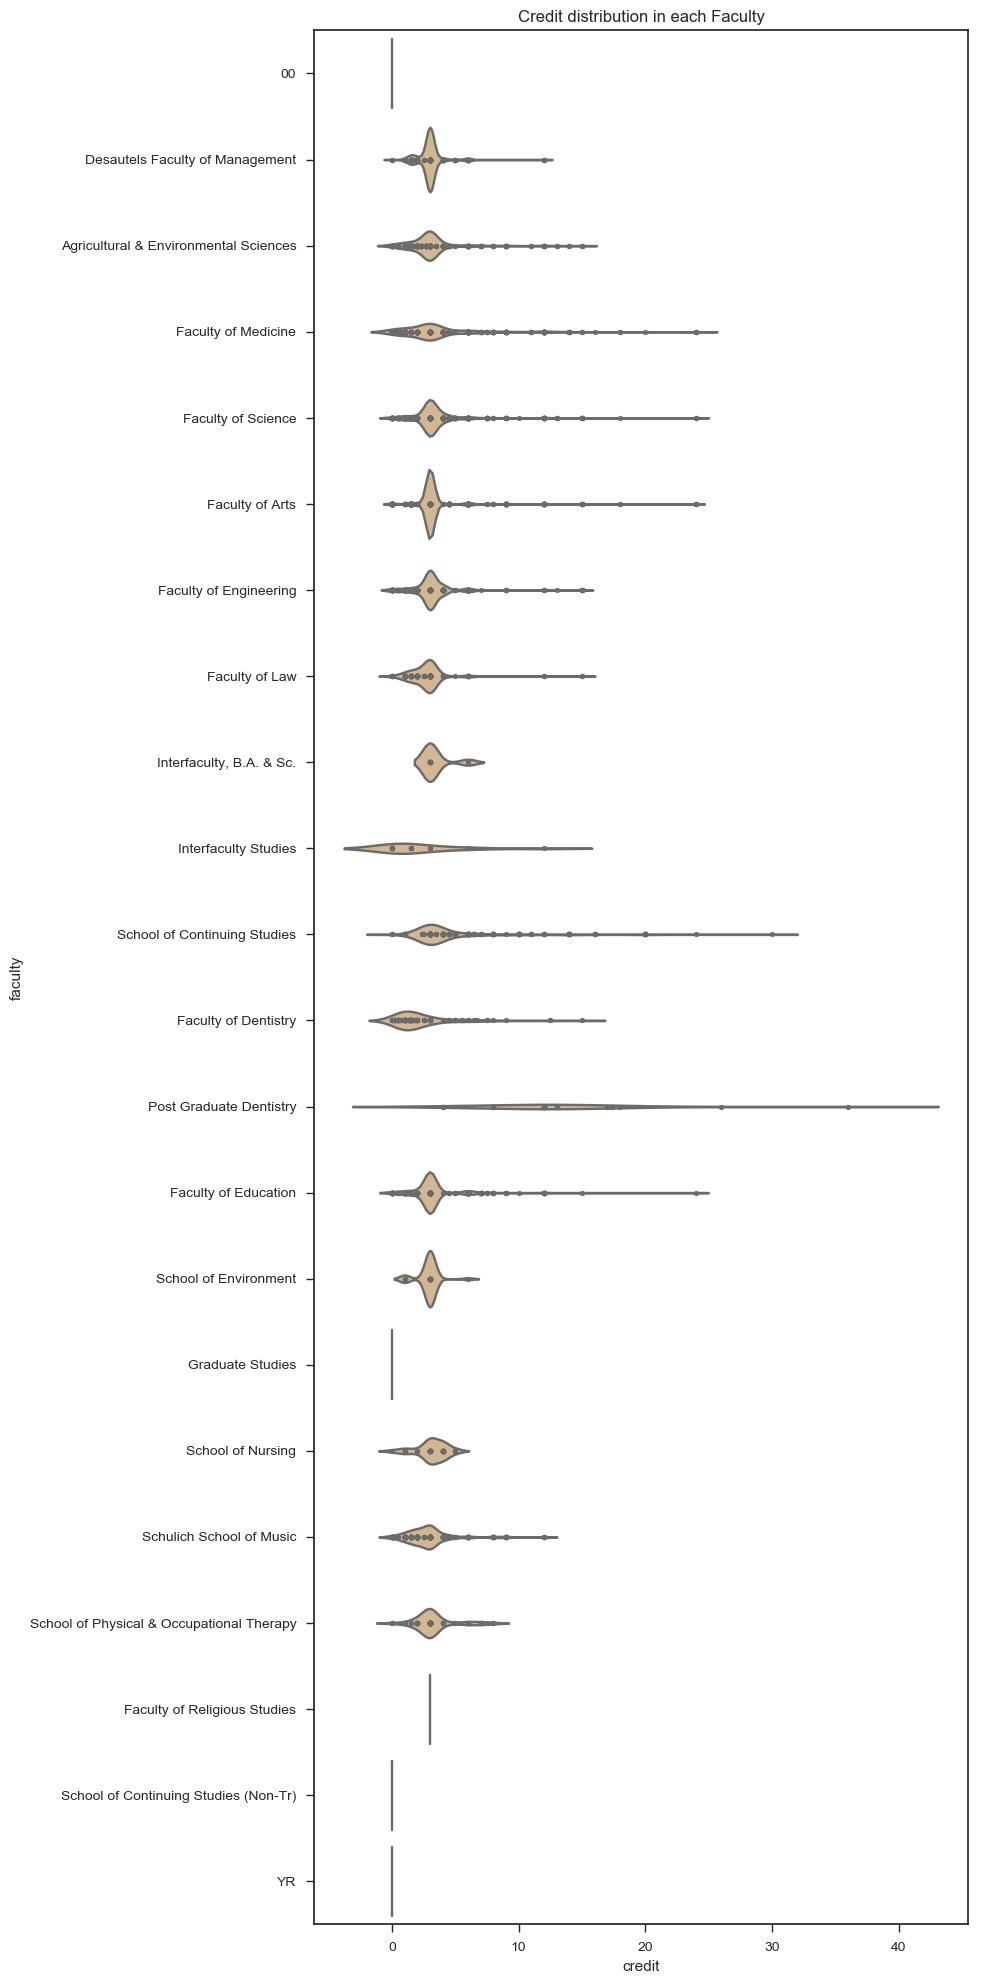

In [9]:
import seaborn as sns
plt.figure(figsize = (10, 20), dpi = 100, facecolor = 'w', edgecolor = 'k')
sns.set(style = "ticks", color_codes = True)
ax = sns.violinplot(y = course_df["faculty"], x = course_df["credit"], color = "burlywood", inner = "point")
plt.title("Credit distribution in each Faculty")
plt.tight_layout()

Conclusion: Although most faculty has its 'violin' largest at 3 credits (mostly 3 credits courses). Post graduate dentistry has a strange distibution...

# 4. What are the most frequent word at course description? (i.e. key word at McGill)

In [10]:
def count_meaningful(text): 
    pat_letter = re.compile(r'[^a-zA-Z \']+')
    new_text = pat_letter.sub(' ', text).strip().lower()
    stopwords = nltk.corpus.stopwords.words('english')
    filtered_words = [word for word in new_text.split() if word not in stopwords]
    noun_only=' '.join(filtered_words).lower()
    tokens = nltk.word_tokenize(noun_only)
    tags = nltk.pos_tag(tokens)
    noun_only = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    fdist1 = nltk.FreqDist(noun_only)
    return fdist1

## 4.1 Key word for McGill? 

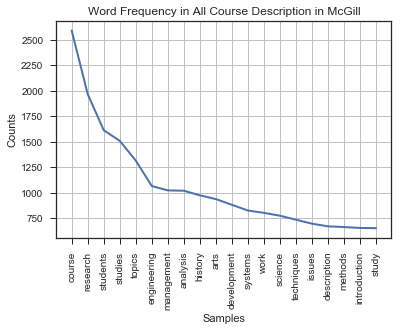

In [11]:
total_descrp = str()
for key, val in course_df['description'].iteritems(): 
    total_descrp = total_descrp + val + ' '
total_dict = count_meaningful(total_descrp)
plt.title("Word Frequency in All Course Description in McGill")
total_dict.plot(20, cumulative = False)

Conclusion: As a research-oriented university serving for 'student' (3rd), McGill has 'research' (2nd) frequently in its 'course' (1st) description. 

## 4.2 Key word for each Faculty? 

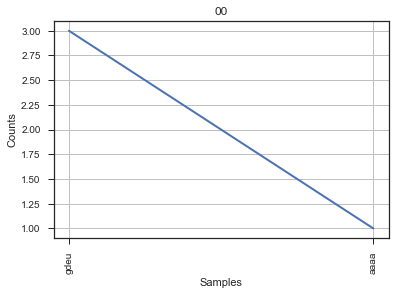

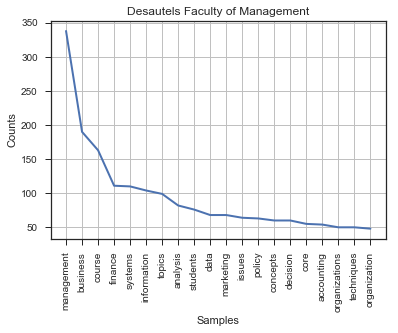

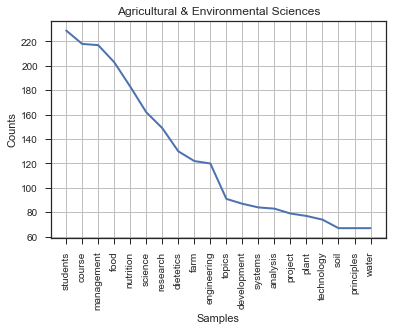

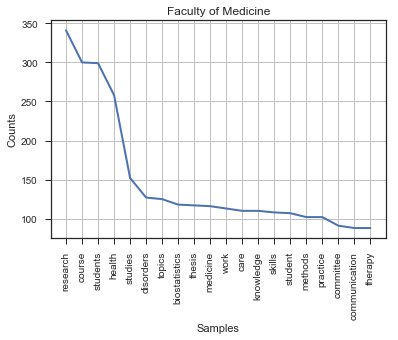

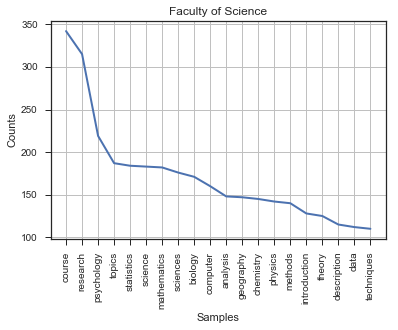

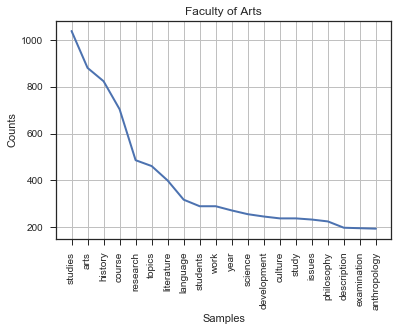

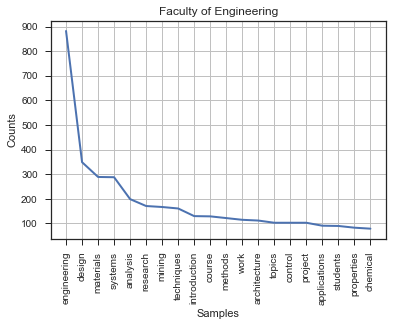

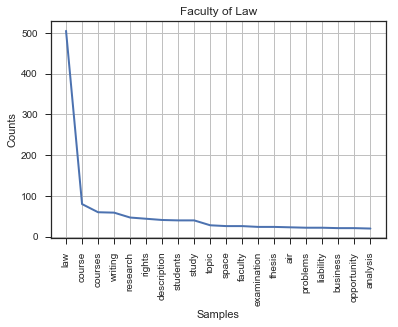

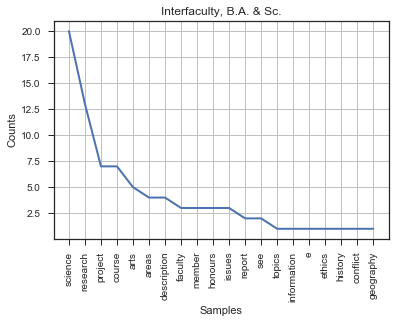

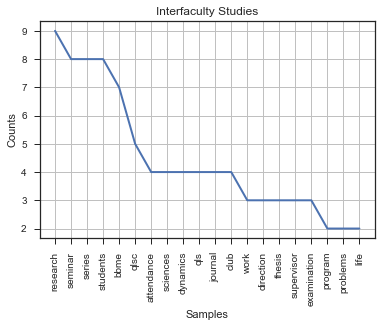

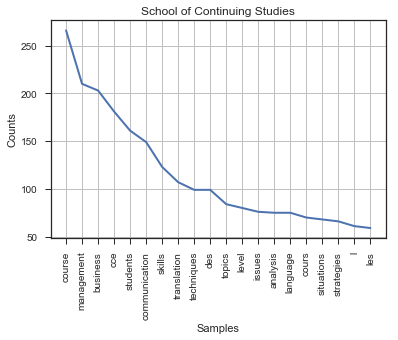

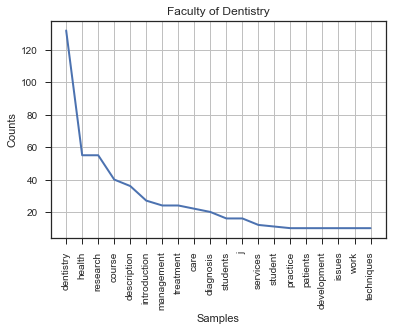

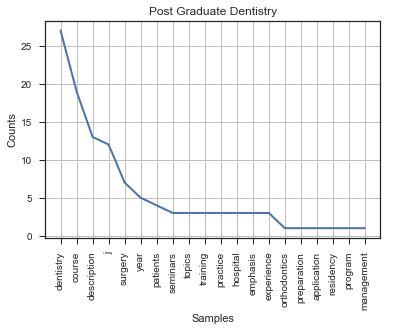

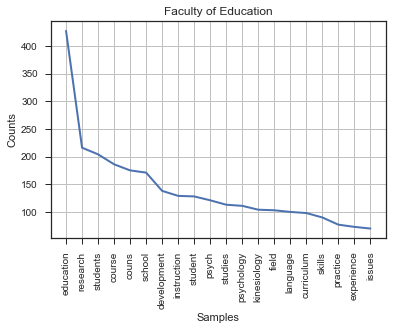

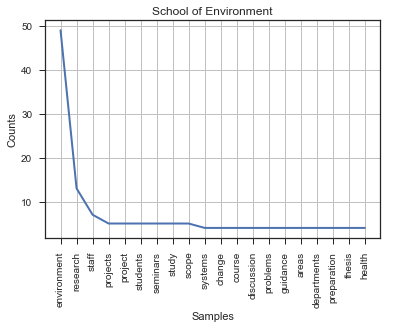

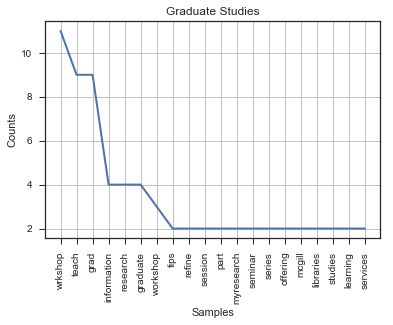

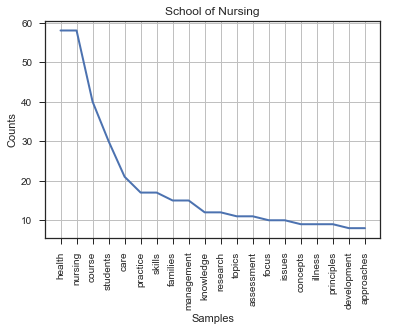

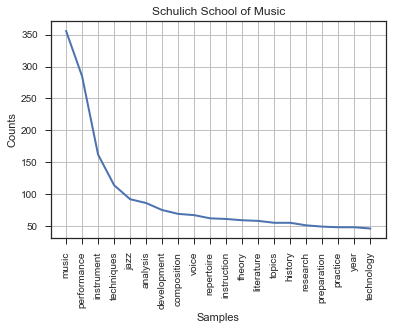

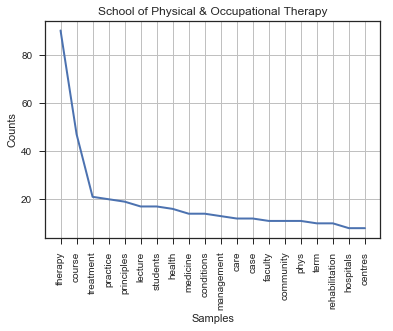

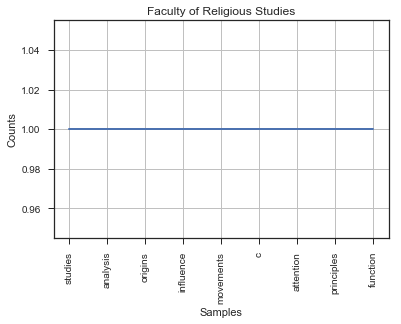

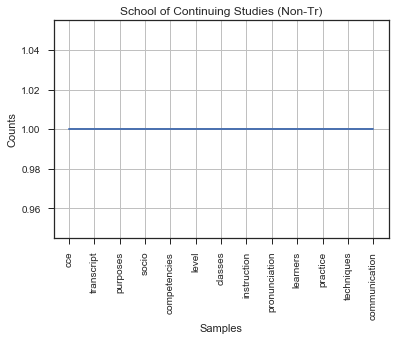

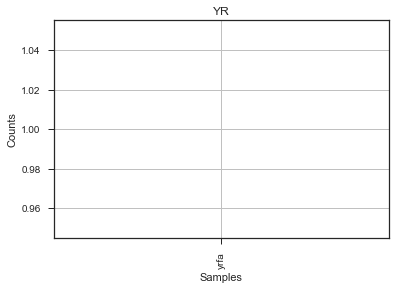

In [12]:
i = 1
for facc in faculties: 
    textfac = str()
    for key, val in course_df.loc[course_df['faculty'] == facc]['description'].iteritems(): 
        textfac = textfac + val + " "
    faccdict = count_meaningful(textfac)
    plt.title(facc)
    faccdict.plot(20,cumulative=False)
    i = i + 1

Conclusion: Most faculty has its name and the future job of graduates as the most frequent word (Management, Engineering, dentistry, education, environment, nursing, music, PTOT and law). Although Science and Medicine are still strongly research-oriented faculties ('Research' is one of the most frequent words). 

# 5. Are 3 credits courses the most frequent?

## 5.1 How are credits distributed? (histogram)

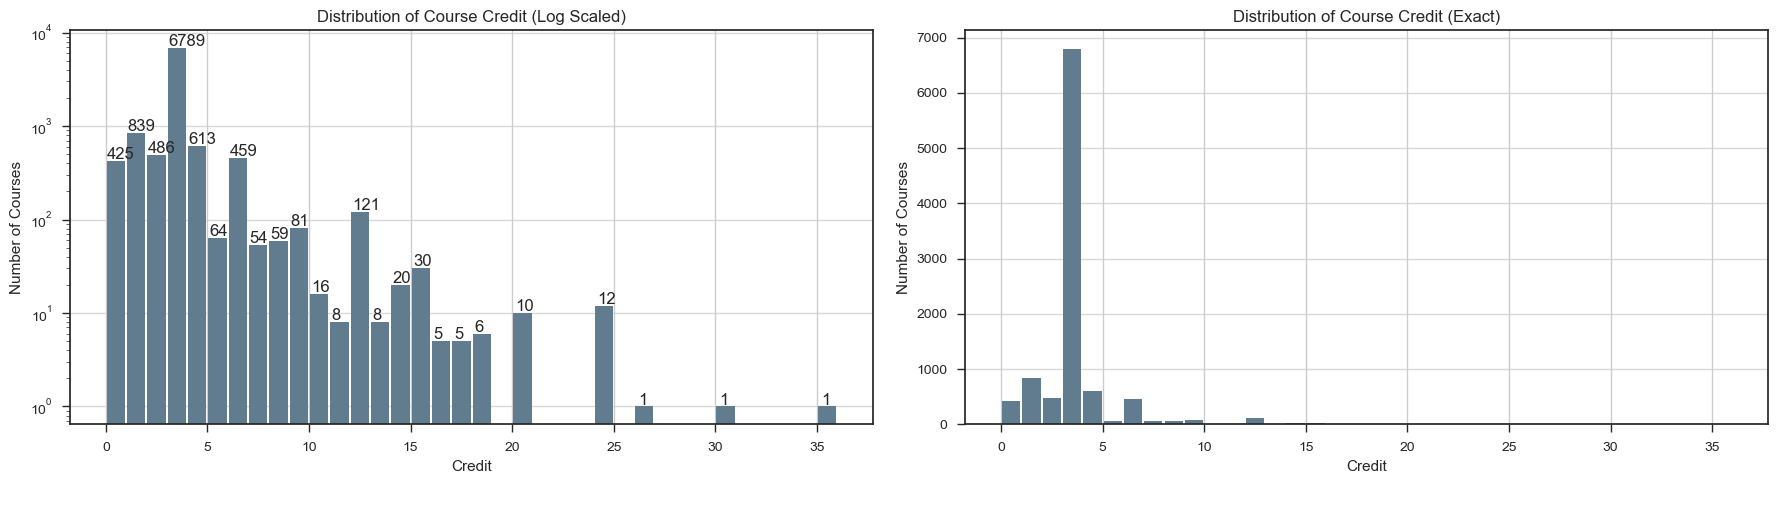

In [13]:
plt.figure(figsize = (18, 5), dpi = 100, facecolor = 'w', edgecolor = 'k')

plt.subplot(1,2,1)

ax = course_df['credit'].plot.hist(grid = True, bins = 36, rwidth = 0.9, color = '#607c8e')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()*1.005, p.get_height() * 1.05))
plt.title('Distribution of Course Credit (Log Scaled)')
plt.xlabel('Credit')
plt.ylabel('Number of Courses')
plt.yscale('log')
plt.grid(axis = 'y', alpha = 0.75)

plt.subplot(1,2,2)

course_df['credit'].plot.hist(grid = True, bins = 36, rwidth = 0.9, color = '#607c8e')
plt.title('Distribution of Course Credit (Exact)')
plt.xlabel('Credit')
plt.ylabel('Number of Courses')
plt.grid(axis = 'y', alpha = 0.75)
plt.tight_layout()

From plot, most courses are 3 credit. Plot on the left is in log-scale in order to visualize counts for low value (eg. count for 36 credit). The plot on the right shows exact distribution. This comparison avoids bias. 

Conclusion: Most of the courses are distributed at 3 credits. 36 credits are the largest credit for a course at McGill.  

# 6. Are all of the courses 100% registered?

## 6.1 To visualize...

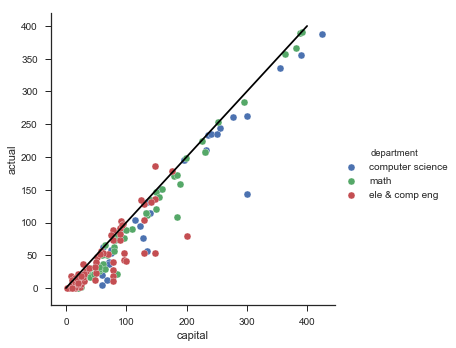

In [14]:
sns.pairplot(x_vars = "capital", y_vars = "actual", data = ecse_math_comp_2018, hue = "department", size = 5)
plt.plot([0, 100,200,300,400], [0, 100,200,300,400], color = 'black')

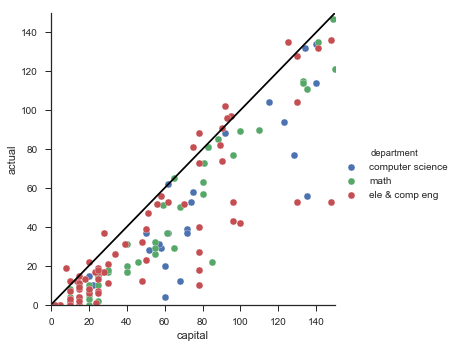

In [15]:
lm = sns.pairplot(x_vars = "capital", y_vars = "actual", data = ecse_math_comp_2018, hue = "department", size = 5)
axes = lm.axes
axes[0,0].set_ylim(0,150)
axes[0,0].set_xlim(0,150)
plt.plot([0, 20, 40, 60, 80, 100, 120, 140, 150], [0, 20, 40, 60, 80, 100, 120, 140, 150], color = 'black')

From plot, almost all points are below y=x. 6 courses from electrical engineering has more students than its capital amount. From 0 to 100, courses are randomly scattered at a triangle, so most courses are not fully registered. However, above 100, most courses are on y=x line. 

## 6.2 T-test (hypothesis test)

For correlated data, pairwise T is used. 

In [16]:
stats.ttest_rel(ecse_math_comp_2018['actual'].values, ecse_math_comp_2018['capital'].values)

Ttest_relResult(statistic=-10.207315986214752, pvalue=1.3106286243012886e-19)

Pairwise T test suggests that overall actual number of registration is significantly different than capital. (pvalue < 0.001)

In [17]:
selector = (ecse_math_comp_2018['actual'] <= 150) & (ecse_math_comp_2018['capital'] <= 150)

In [18]:
stats.ttest_rel(ecse_math_comp_2018[selector]['actual'].values, ecse_math_comp_2018[selector]['capital'].values)

Ttest_relResult(statistic=-10.947949089545443, pvalue=8.349560558530365e-21)

Pairwise T test suggests that for courses with less than 150 student, actual number of registration is significantly different than capital.
(pvalue < 0.001)

In [19]:
stats.ttest_rel(ecse_math_comp_2018[~selector]['actual'].values, ecse_math_comp_2018[~selector]['capital'].values)

Ttest_relResult(statistic=-3.2372329849281827, pvalue=0.002808173673297686)

Pairwise T test suggests that for courses with more than 150 student, actual number of registration is same than capital. (pvalue > 0.001)

In [20]:
diff = np.subtract(ecse_math_comp_2018[selector]['actual'].values, ecse_math_comp_2018[selector]['capital'].values)

In [21]:
ci = stats.t.interval(0.995, len(diff)-1, loc = 0, scale = stats.sem(diff))
len_ci = (ci[-1] - ci[0]) / 2

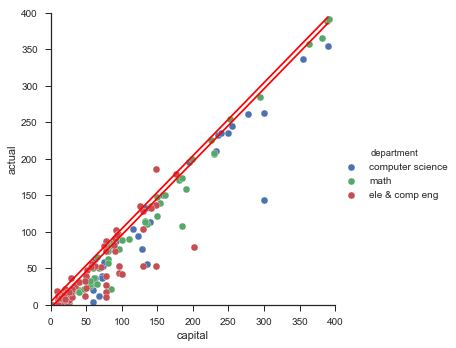

In [22]:
lm = sns.pairplot(x_vars = "capital", y_vars = "actual", data = ecse_math_comp_2018, hue = "department", size = 5)
axes = lm.axes
xy = [i for i in range(0, 400, 10)]
axes[0,0].set_ylim(0,400)
axes[0,0].set_xlim(0,400)
plt.plot(xy, np.add(xy, len_ci), color = 'red')
plt.plot(xy, np.subtract(xy, len_ci), color = 'red')

This diagram plots a boundary for courses that are fully registered, using confidence level: 0.0025. 

Conclusion: for small courses, they are not fully registered. However, large course, they are fully registered. 

# Predicting number of actual registered students Computer Science courses 

# 1. Ordinary Multiple Linear Regression

In [23]:
def split_test_val_train(datas): 
    
    msk=np.random.rand(len(datas)) < 0.8
    non_test = datas[msk].copy()
    test = datas[~msk].copy()
    
    msk1 = np.random.rand(len(non_test)) < 0.66
    train = non_test[msk1].copy()
    validation = non_test[~msk1].copy()
    
    return train, validation, test


def split_test_val(datas): 
    
    msk=np.random.rand(len(datas)) < 0.8
    non_test = datas[msk].copy()
    test = datas[~msk].copy()
    
    return non_test, test


def forward_selection(potential_predictor_lists, data, Y_query): 
    
    model = LinearRegression(fit_intercept=True)
    train, validation, test = split_test_val_train(data)
    
    y_train = train[Y_query].values
    y_validation = validation[Y_query].values
    y_test = test[Y_query].values
    
    total_predictors = potential_predictor_lists
    predictors = [([], 0)]
    
    for k in range(1, len(total_predictors)): 
        
        best_k_min_1 = predictors[-1][0]
        new_predictr = list(set(total_predictors) - set(best_k_min_1))
        
        eval_m = []
        
        for predictor in new_predictr: 
            
            current_predictors = best_k_min_1 + [predictor]
            
            X_train = train[current_predictors].values
            X_validation = validation[current_predictors].values
            
            if k == 1:
                X_train = X_train.reshape((len(X_train), 1))
                
            model.fit(X_train, y_train)
            eval_m.append(model.score(X_validation, y_validation))
            
        predictors.append((best_k_min_1 + [new_predictr[np.argmax(eval_m)]], np.max(eval_m)))
        
    X_train = train[total_predictors].values
    X_validation = validation[total_predictors].values  
    
    model.fit(X_train, y_train)
    predictors.append((total_predictors, model.score(X_validation, y_validation)))
    best_r2_tup = sorted(predictors, key=lambda t: t[1])[-1]
    
    X_train = train[best_r2_tup[0]].values
    X_test = test[best_r2_tup[0]].values  
    
    model.fit(X_train, y_train)


    return best_r2_tup[0], model.intercept_, model.coef_, best_r2_tup[-1], model.score(X_test, y_test)

Conclusion: 

In [24]:
best_r2_tup = forward_selection(['course_number', 'term', 'days', 'location', 'sec_type', 'time_start'], comp_long_term, 'actual')
print('best combination of predictors are: {},\nmodel is y = {} * X + {},\ntrain R^2 is {}, and test R^2 is {}'.format(best_r2_tup[0], best_r2_tup[2], best_r2_tup[1], best_r2_tup[3], best_r2_tup[4]))

best combination of predictors are: ['course_number', 'term', 'location', 'days', 'sec_type'],
model is y = [-0.14973602  1.94848361  1.32239031  0.5103179  -0.40422738] * X + 69.34337619805746,
train R^2 is 0.35572095943871795, and test R^2 is 0.45907764848674293


# 2. Polynomial and interaction

## PCA is used to reduce dimension created by polynomial feature, largest variance means more information
## Cross validation is used to aviod overfitting on validation set and training set and select degree and interaction terms

In [25]:
non_test, test = split_test_val(comp_long_term)

y_non_test = non_test['actual'].values
y_test = test['actual'].values

In [26]:
min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(non_test[features].values)
X_test = min_max_scaler.fit_transform(test[features].values)

In [27]:
poly = PolynomialFeatures(degree=5, include_bias=False, interaction_only=False)
X_non_test_poly = poly.fit_transform(X_non_test)
X_test_poly = poly.fit_transform(X_test)

In [28]:
pca = PCA(n_components=461)

pca.fit(X_non_test_poly)

X_non_test_pca = pca.transform(X_non_test_poly)
X_test_pca = pca.transform(X_test_poly)

print('Top 20 variance:', pca.explained_variance_ratio_[:50])

Top 20 variance: [2.69472840e-01 2.03045650e-01 1.53392894e-01 1.08836364e-01
 6.42177350e-02 4.28018840e-02 3.40686601e-02 2.07391801e-02
 1.38925494e-02 1.24361368e-02 1.00418074e-02 7.39972719e-03
 6.67339772e-03 6.41434474e-03 5.35590768e-03 4.31579201e-03
 4.03702056e-03 3.71454878e-03 3.37738228e-03 2.67908601e-03
 2.35036795e-03 2.15919327e-03 1.94152805e-03 1.72356889e-03
 1.61392086e-03 1.40510078e-03 1.23736724e-03 9.81602812e-04
 9.64834358e-04 7.40863630e-04 6.20491192e-04 5.66663056e-04
 5.07876364e-04 4.42404308e-04 3.89999384e-04 3.76848439e-04
 3.64456587e-04 3.31461173e-04 2.94220704e-04 2.77706285e-04
 2.53336126e-04 2.31801613e-04 2.13881209e-04 1.86430189e-04
 1.80234157e-04 1.64351546e-04 1.58807902e-04 1.54061922e-04
 1.37616122e-04 1.34672760e-04]


In [29]:
model = LinearRegression(fit_intercept=True)

kf = KFold(n_splits=5)

cv_score = []

for n in range(1, 461):
    
    pca = PCA(n_components=n)
    pca.fit(X_non_test_poly)
    
    val_score = []
    
    for train_index, val_index in kf.split(X_non_test_pca):
        
        X_train, X_val = X_non_test_poly[train_index], X_non_test_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        model.fit(X_train_pca, y_train)
        val_score.append(model.score(X_val_pca, y_val))
        
    cv_score.append(np.mean(val_score))

In [30]:
best_cv = range(1, 461)[np.argmax(cv_score)]

pca = PCA(n_components=best_cv)
pca.fit(X_test_poly)
X_train_pca = pca.transform(X_non_test_poly)
X_test_pca = pca.transform(X_test_poly)

model.fit(X_train_pca, y_non_test)
test_R2 = model.score(X_test_pca, y_test)

Conclusion: 

In [31]:
print('best regularization param are first: {} parameters'.format(best_cv))
print('test R^2 is: ',test_R2)

best regularization param are first: 21 parameters
test R^2 is:  0.6138896684477178
